In this notebook, we will build an agent that acts as a restaurant waiter, capable of interacting with customers, answering their questions about the menu, and providing friendly responses. We will use the LangChain and LangGraph libraries to construct the agent's workflow and integrate it with OpenAI's GPT-based language models.

# Libraries, API Keys and Data

We need to install several libraries to build our agent:
*   langchain-community and langchain-openai: For language model integrations and prompts.
*   unstructured: For document loading and processing.
*   faiss-cpu: For vector similarity search.
*   langgraph: For constructing the workflow graph.

In [ ]:
!pip install -q langchain-community langchain-openai unstructured faiss-cpu langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 29.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.0/55.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.2/413.2 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.1/167.1 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━

We import necessary modules from LangChain and LangGraph. Make sure your OpenAI API key is stored with the key 'genai_course' in Colab's user data.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
from google.colab import userdata
api_key = userdata.get('OPENAI')

In [ ]:
%cd /content/drive/MyDrive/GenAI/RAG/Agentic RAG

/content/drive/MyDrive/GenAI/RAG/Agentic RAG


In [ ]:
from langchain_community.document_loaders import UnstructuredExcelLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores.faiss import FAISS
from langchain.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.schema.output_parser import StrOutputParser

from typing import List
from typing_extensions import TypedDict
from IPython.display import display, Image

from langgraph.graph import StateGraph, END

In [ ]:
# Loads the document
file = 'dim sum montijo.xlsx'
loader = UnstructuredExcelLoader(file, mode = 'elements')
data = loader.load()

# Embedding
embeddings = OpenAIEmbeddings(
    openai_api_key = api_key
)

# Store in a vector database
db = FAISS.from_documents(data, embeddings)

# Process

In [ ]:
# TypedDict class to store information
class AgentState(TypedDict):
  start: bool
  conversation: int # Keep track on conversation
  question: str # Question to ask the llm
  answer: str # Output of the LLM
  topic: bool # Decision on whether the question makes sense / can be answered
  documents: list # Relevant documents
  recursion_limit: int # Avoid endless loops
  memory: list

In [ ]:
# Build a function to greet the customer
def greetings(state):
  print("Hello! Welcome to the restaurant. I will be your waiter. How can I help you?")
  user_input = input()

  state['question'] = user_input
  state['conversation'] = 1
  state['memory'] = [user_input]

  return state

In [ ]:
def check_question(state):

  # Get the question
  question = state['question']

  # Define the system prompt
  system_prompt = """
  ### Persona:
  You are an AI Assistant working as a restaurant service evaluator.
  Your task is to analyze customer questions directed at the restaurant staff
  and determine whether they are appropriate.

  ### Task:
  - Assess if the customer's question is suitable for restaurant staff.
  - If the question is related to food, drinks, reservations, or restaurant services, classify it as "True".
  - If the question is unrelated to the restaurant (e.g., personal, off-topic, inappropriate), classify it as "False".
  - Your response must be only "True" or "False" without any explanations.

  ### Guidelines:
  1. Acceptable questions include:
  - "What are today’s specials?"
  - "Do you have vegetarian options?"
  - "Can I book a table for 7 PM?"
  - "What time do you close?"

  2. Unacceptable questions include:
  - "What’s your favorite movie?"
  - "Can you help me with my homework?"
  - "Do you believe in aliens?"
  - "How can I invest in stocks?"

  ### Response Format:
  - If the question is appropriate → Respond with **"True"**.
  - If the question is inappropriate → Respond with **"False"**.
  - Do not provide any explanations, additional text, or formatting.onse.
  """

  # Prompt template to format the system prompt
  TEMPLATE = ChatPromptTemplate.from_messages([
      ("system", system_prompt),
      ("human", f"User question: {question}")
  ])
  prompt = TEMPLATE.format(question = question)

  # Call the LLM model
  model = ChatOpenAI(model = "gpt-4o-mini",
                    api_key = api_key)

  # Invoke the model with the prompt
  response_text = model.invoke(prompt)

  # Update the state with the model's decision
  state['topic'] = response_text.content.strip()

  return state

In [ ]:
# Function to check if the LLM model decides if the question is on topic or not
def topic_router(state):
  topic = state['topic']
  if topic == 'True':
    return "on_topic"
  else:
    return "off_topic"

# Function for when the question is NOT on topic
def off_topic_response(state):
  if state['conversation'] <= 1:
    state['answer'] = "\nI apologize, I can't answer that question. I can only answer questions about the menu in this restaurant"
    print(state["answer"])
  else:
    state['answer'] = "\nHappy to help"
    print(state['answer'])

In [ ]:
# Function to retrieve relevant documents based on the question
def retrieve_docs(state):
  memory = ", ".join(state['memory'])

  # Get the context
  docs_faiss = db.similarity_search(str(memory), k = 5)
  state['documents'] = [doc.page_content for doc in docs_faiss]

  return state

In [ ]:
# Build a function to generate the questions
def generate(state):
  # Initializing the model
  model = ChatOpenAI(model="gpt-4o-mini", api_key=api_key)

  # Extract the infromation
  question = state['question']
  documents = state['documents']
  memory = state['memory']

  # Define the system prompt for the model
  system_prompt = """
  ### Role:
  You are a restaurant waiter assisting customers by answering their questions in a polite and professional manner.

  ### Instructions:
  - Provide concise and clear responses.
  - Maintain a friendly and helpful tone.
  - Avoid excessive detail; keep answers to the point.
  - Do **not** refer to yourself as a "waiter" or explicitly mention your role.
  - Respond naturally, as a human waiter would in conversation.

  ### Example Interactions:

  **Customer:** "What are today’s specials?"
  **Response:** "Today's specials are grilled salmon with lemon butter sauce and a creamy mushroom risotto."

  **Customer:** "Do you serve vegetarian dishes?"
  **Response:** "Yes, we have several vegetarian options, including a roasted vegetable pasta and a lentil curry."

  **Customer:** "Can I book a table for 7 PM?"
  **Response:** "Of course! How many people will be dining with you?"

  Your goal is to provide helpful, natural, and professional responses to customers' inquiries.
  """

  # Create a prompt template for formating
  TEMPLATE = ChatPromptTemplate.from_messages([
      ("system", system_prompt),
      ("human", f"Context: {documents}\nConversation history so far: {memory}\nCustomer question: {question}")
  ])

  # Format the prompt
  prompt = TEMPLATE.format(documents = documents, memory = memory, question = question)

  # Invoke the model with the prompt
  response_text = model.invoke(prompt)

  # Update the state with the model's decision
  state['answer'] = response_text.content.strip()
  # print(state['state'])

  return state

In [ ]:
# Build a function that improves the generated answer
def improve_answer(state):
  question = state['question']
  answer = state['answer']
  memory = state['memory']

  # Define the system prompt
  system = """
  ### Role:
  You are a restaurant waiter responsible for reviewing and refining responses given to customers. Your task is to ensure the response is appropriate, friendly, and informative while maintaining a polite, professional, and attentive tone.

  ### Instructions:
  - Review the provided response to ensure clarity, correctness, and relevance.
  - Edit or remove parts as needed to improve conciseness and professionalism.
  - **Do not add** any new information beyond what is given.
  - Maintain a warm, engaging, and helpful tone.
  - Always conclude with an open-ended question to encourage further conversation.
  - Consider the conversation history to make responses more personalized and useful.
  - Format the response with `\n` at each sentence or logical break.
  - **Do not include any introductory phrases, explanations, or commentary—only return the refined response.**

  ### Example Refinements:

  **Original Response:**
  *"Yes, we have a few vegetarian options, such as salads and pasta dishes. We also have a delicious lentil soup that’s really popular. Let me know if you’d like recommendations!"*

  **Refined Response:**
  *"Yes, we offer several vegetarian options, including fresh salads, pasta dishes, and a hearty lentil soup.\n Would you like a recommendation based on your preferences?"*

  ---

  **Original Response:**
  *"We close at 10 PM, but sometimes we stay open later if it’s busy. If you’re planning to visit late, you might want to call ahead to check. Hope that helps!"*

  **Refined Response:**
  *"Our restaurant closes at 10 PM, though we may stay open later during busy nights.\n Would you like me to assist with a reservation?"*

  ### **Final Instruction:**
  Deliver a refined response that enhances the customer's experience and reflects the restaurant's commitment to customer service.
  """
  # Prompt Template
  TEMPLATE = ChatPromptTemplate.from_messages([
    ("system", system),
    ("human", f"Customer question: {question}, Conversation history: {memory}, waiter answer: {answer}")
  ])

  # Call the LLM
  model = ChatOpenAI(model = "gpt-4o-mini",
                     api_key = api_key)
  prompt = TEMPLATE.format(question = question, memory = memory, answer = answer)
  response_text = model.invoke(prompt)

  # Store the answer in AgentState
  state['answer'] = response_text.content
  print("\n")
  print(state['answer'])
  state['memory'].append(response_text.content)

  return state

In [ ]:
# Build a function to repeatedly ask for the user's input
def further_question(state):
  print('\n')
  user_input = input()

  state['question'] = user_input
  state['conversation'] += 1
  state['memory'].append(user_input)

  return state

# Workflow

In [ ]:
# Initialize a StateGraph
workflow = StateGraph(AgentState)

# Defining the nodes
workflow.add_node("greetings", greetings)
workflow.add_node("check_question", check_question)
workflow.add_node("off_topic_response", off_topic_response)
workflow.add_node("retrieve_docs", retrieve_docs)
workflow.add_node("generate", generate,)
workflow.add_node("improve_answer", improve_answer)
workflow.add_node("further_question", further_question)

# Set the entry point to the workflow
workflow.set_entry_point("greetings")

# Add the conditional
workflow.add_conditional_edges(
    "check_question",
    topic_router,
    {
        "on_topic": "retrieve_docs",
        "off_topic": "off_topic_response"
    }
)

# Add sequential edges
workflow.add_edge("greetings", "check_question")
workflow.add_edge("retrieve_docs", "generate")
workflow.add_edge("generate", "improve_answer")
workflow.add_edge("improve_answer", "further_question")
workflow.add_edge("further_question", "check_question")

# Connect the nodes to the end
workflow.add_edge("off_topic_response", END)

# Compile the workflow into an application
app = workflow.compile()

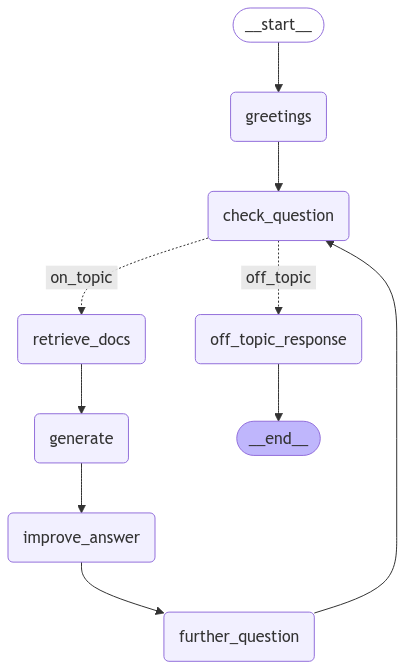

In [ ]:
# Preview the workflow
display(Image(app.get_graph(xray = True).draw_mermaid_png()))

In [ ]:
result = app.invoke({"start": True}, {"recursion_limit": 50})

Hello! Welcome to the restaurant. I will be your waiter. How can I help you?
What do you recommend?


*I highly recommend our Siao Long Pao, which are delightful dumplings filled with pork, paksoy, and shiitake mushroom.  
 They’re a favorite among our guests!  
 If you prefer something lighter, our vegetarian soup is also an excellent choice.  
 What type of flavors or dishes do you enjoy?*


What's the menu?


*Our menu features a variety of delicious options, including soups like Won Ton Soup and Vegetarian Soup.  
 We also offer a selection of rice dishes, traditional dumplings such as Siao Long Pao and Gyozas, as well as steamed buns and crepes.  
 For appetizers, don’t miss our crunchy selections like Fortune Bags and Shanghai Prawns.  
 For dessert, you can enjoy our Banana & Chocolate Crepe or Mochis.  
 Additionally, we have a selection of teas, soft drinks, and wines.  
 Would you like more details on any specific dishes or categories?*


Wha'ts your reco?


*I recommend our 